In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### INSPECTION REPORT DATA (Source: Inpection Reports/Ancine)

Os relatórios de fiscalização são as apurações anuais da Cota de Tela realizadas pelo setor responsável pela fiscalização da Ancine.

As apurações são públicas e estão [disponíveis](https://www.gov.br/ancine/pt-br/assuntos/atribuicoes-ancine/fiscalizacao/cinema) no sítio eletrônico da Agência.

*Inspection reports annually tally Screen Quota obligations for and fulfillments from each movie theater*

*Reports are put together by the Inspection office at Ancine and are publicly [available](https://www.gov.br/ancine/pt-br/assuntos/atribuicoes-ancine/fiscalizacao/cinema) at the agency's website*

#### Import, merge and handle group missing values; gets info from executive order

In [2]:
# importing reports from 2017 and 2018; 2019 had no screen quota in effect

cota_17 = pd.read_excel('Relat_rio_de_Aferi__o_Cota_de_Tela_-_2017.xlsx')

cota_18 = pd.read_excel('Relat_rio_de_Aferi__o_Cota_de_Tela_-_2018.xlsx')

In [3]:
cota17_trab = cota_17.copy()

cota18_trab = cota_18.copy()

cota18_trab = cota18_trab[cota18_trab['REGISTRO DO COMPLEXO'].notna()] # removing movie theaters with no id

# inserting year info in each report

cota17_trab['ANO_CINEMATOGRAFICO'] = 2017
cota18_trab['ANO_CINEMATOGRAFICO'] = 2018

# some multiplexes have no info on quota fulfillments, because nothing was reported to Ancine
# here, I define quota fulfillments of missing reports as ZERO

cota17_trab['Nº DE DIAS VALIDADOS (COTA DE TELA)'] = cota17_trab['Nº DE DIAS VALIDADOS (COTA DE TELA)'].fillna(value=0)

cota18_trab['Nº DE DIAS VALIDADOS (SCB) '] = cota18_trab['Nº DE DIAS VALIDADOS (SCB) '].fillna(value=0)

# some guys w/o valid reports to SCB have no info on proportional (to opening days) obligations --- just three guys
# for these I'm setting prop quota to be equal to the final one (after transfers)

for i in cota17_trab[cota17_trab['OBRIGAÇÃO COTA DE TELA - SAM'].isna()].index:
    cota17_trab.loc[i,'OBRIGAÇÃO COTA DE TELA - SAM'] = cota17_trab.loc[i,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL']

In [4]:
# importing data from the exec order setting quota obligations, 2017 and 2018 were the same

decreto = pd.read_excel('Decreto cota de tela 2017-2018.xlsx', index_col=0)

In [5]:
## def function of total obligation, because multiplexes with more than 20 rooms do not have an explicitly defined obligation

def obr_total(n_salas):
    if n_salas <= 20: # < 20, just get info from exec order
        return decreto.loc[n_salas, 'Cota por complexo']
    else: # else, must calculate using the orders' rule
        return (800 + 7*(n_salas - 20))

In [6]:
# applying function to reports (note that reports originally display only quota obligations proportional to opening days)

cota17_trab.loc[:,'OBRIGAÇÃO_TOTAL'] = cota17_trab['TOTAL SALAS DO COMPLEXO'].apply(obr_total)
cota18_trab.loc[:,'OBRIGAÇÃO_TOTAL'] = cota18_trab['TOTAL SALAS DO COMPLEXO'].apply(obr_total)

# adding values from IN 117 "predatory occupation"

cota17_trab.loc[:,'OBRIGAÇÃO_TOTAL_INCREMENTO'] = cota17_trab.loc[
    :,'OBRIGAÇÃO_TOTAL'] + cota17_trab.loc[:,'INCREMENTO IN 117 (Ocupação de um Título em ']
cota17_trab.loc[:,'OBRIGAÇÃO_PROP_INCREMENTO'] = cota17_trab.loc[:,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL'] + cota17_trab.loc[:,'INCREMENTO IN 117 (Ocupação de um Título em ']

# disregarding IN 117 values for movie theaters that got a judicial order waiving the rule
for i in range(cota18_trab.shape[0]):
    cota18_trab.loc[i,'OBRIGAÇÃO_TOTAL_INCREMENTO'] = cota18_trab.loc[i,'OBRIGAÇÃO_TOTAL'] if cota18_trab.loc[i,'Afastada aplicação do acréscimo (art. 3º-A) por Decisão Judicial'] == 'SIM' else cota18_trab.loc[i,'OBRIGAÇÃO_TOTAL'] + cota18_trab.loc[i,'Acréscimo (art. 3º-A)']

In [7]:
# renaming cols to match and merge

cota17_trab.columns = ['REGISTRO DO GRUPO', 'NOME DO GRUPO', 'REGISTRO DA EMPRESA',
       'NOME DA EMPRESA', 'REGISTRO DO COMPLEXO', 'NOME DO COMPLEXO',
       'TOTAL SALAS DO COMPLEXO', 'Nº DE DIAS OBRIGAÇÃO',
       'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL',
       'INCREMENTO IN 117 (Ocupação de um Título em ',
       'TRANSF_ORIGEM', 'TRANSF_RECEBIDOS',
       'OBG_FINAL', 'Nº DE DIAS VALIDADOS',
       'Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO',
       'Nº DE TÍTULOS DIFERENTES DECLARADOS', 'CUMPRIU COTA', 'ANO_CINEMATOGRAFICO',
       'OBRIGAÇÃO_TOTAL', 'OBRIGAÇÃO_TOTAL_INCREMENTO',
       'OBRIGAÇÃO_PROP_INCREMENTO']

cota18_trab.columns = ['REGISTRO DO GRUPO', 'NOME DO GRUPO', 'REGISTRO DA EMPRESA',
       'NOME DA EMPRESA', 'REGISTRO DO COMPLEXO', 'NOME DO COMPLEXO', 'UF',
       'TOTAL SALAS DO COMPLEXO', 'Nº DE DIAS OBRIGAÇÃO',
       'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL', 'Acréscimo (art. 3º-A)',
       'Afastada aplicação do acréscimo (art. 3º-A) por Decisão Judicial',
       'OBRIGAÇÃO_PROP_INCREMENTO',
       'TRANSF_ORIGEM',
       'TRANSF_RECEBIDOS', 'OBG_FINAL',
       'Nº DE DIAS VALIDADOS', 'Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO',
       'Nº DE TÍTULOS DIFERENTES DECLARADOS', 'CUMPRIU COTA', 'ANO_CINEMATOGRAFICO',
       'OBRIGAÇÃO_TOTAL', 'OBRIGAÇÃO_TOTAL_INCREMENTO']

In [8]:
# selecting cols to concat

cota17 = cota17_trab[['ANO_CINEMATOGRAFICO', 'REGISTRO DO GRUPO', 'NOME DO GRUPO', 'REGISTRO DA EMPRESA',
       'NOME DA EMPRESA', 'REGISTRO DO COMPLEXO', 'NOME DO COMPLEXO',
       'TOTAL SALAS DO COMPLEXO','Nº DE DIAS OBRIGAÇÃO PROPORCIONAL',
        'OBRIGAÇÃO_TOTAL_INCREMENTO', 'OBRIGAÇÃO_PROP_INCREMENTO', 'OBRIGAÇÃO_TOTAL', 'OBG_FINAL',
        'Nº DE DIAS VALIDADOS', 'Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO',
       'Nº DE TÍTULOS DIFERENTES DECLARADOS', 'CUMPRIU COTA',
        'TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']]

cota18 = cota18_trab[['ANO_CINEMATOGRAFICO','REGISTRO DO GRUPO', 'NOME DO GRUPO', 'REGISTRO DA EMPRESA',
       'NOME DA EMPRESA', 'REGISTRO DO COMPLEXO', 'NOME DO COMPLEXO',
       'TOTAL SALAS DO COMPLEXO','Nº DE DIAS OBRIGAÇÃO PROPORCIONAL',
        'OBRIGAÇÃO_TOTAL_INCREMENTO', 'OBRIGAÇÃO_PROP_INCREMENTO', 'OBRIGAÇÃO_TOTAL', 'OBG_FINAL',
        'Nº DE DIAS VALIDADOS','Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO',
        'Nº DE TÍTULOS DIFERENTES DECLARADOS', 'CUMPRIU COTA',
        'TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']]

In [9]:
# merging

cota = pd.concat([cota17, cota18], axis = 0)
cota.reset_index(inplace=True)

In [10]:
# handle missing group values. for independent multiplexes (i.e. not belonging to a group) and I use company id instead

cota['REGISTRO DO GRUPO'] = cota['REGISTRO DO GRUPO'].fillna(value=False)

for i in range(cota.shape[0]):
    if cota.loc[i,'REGISTRO DO GRUPO'] == False: # if there is no group info
        cota.loc[i,'REGISTRO DO GRUPO'] = cota.loc[i,'REGISTRO DA EMPRESA'] # use the name of company

In [11]:
# splitting versions s.t. this one can be used for group-level aggregation

cota_para_grupo = cota.copy()

#### Linking multiplex information to group-level aggs so that group info can be added to SCB data

*Recall that SCB data only has multiplex id, and no group id*

In [12]:
# relates multiplexes to groups

complexo_grupo = cota.groupby(['REGISTRO DO COMPLEXO']).agg({
    'REGISTRO DO GRUPO':'first', 'NOME DO GRUPO':'first'
})

# gets relevant infos aggregated at group levels --- no. of viewing rooms, companies and movie theaters

anexo = cota.groupby(['ANO_CINEMATOGRAFICO','REGISTRO DO GRUPO']).agg({
    'NOME DO GRUPO':'first','REGISTRO DA EMPRESA':'count','REGISTRO DO COMPLEXO':'count',
    'TOTAL SALAS DO COMPLEXO':'sum'
})

for i in complexo_grupo.index:
    g = complexo_grupo.loc[i,'REGISTRO DO GRUPO'] # get group id
    if g in anexo.loc[2018].index:
        for c in ['REGISTRO DA EMPRESA','REGISTRO DO COMPLEXO','TOTAL SALAS DO COMPLEXO']:
            complexo_grupo.loc[i,c] = anexo.loc[(2018,g), c] # pastes group-level info at multiplex ids
    else: # same for 2017
        for c in ['REGISTRO DA EMPRESA','REGISTRO DO COMPLEXO','TOTAL SALAS DO COMPLEXO']:
            complexo_grupo.loc[i,c] = anexo.loc[(2017,g), c]
            
# rename cols for inteligibility 

complexo_grupo.columns = ['REGISTRO DO GRUPO', 'NOME DO GRUPO', 'QTDE_EMPRESAS_GRUPO',
       'QTDE_COMPLEXOS_GRUPO', 'TOTAL_SALAS_GRUPO']

In [13]:
# export

complexo_grupo.to_csv('Complexo_grupo.csv')

#### Adds columns with quota obligations proportional to the number of **viewing rooms**

In [14]:
# total obligation per viewing room (VR)
cota.loc[:,'OBRIGAÇÃO_TOTAL_POR_SALA'] = (cota.loc[:,'OBRIGAÇÃO_TOTAL'] / cota.loc[:,'TOTAL SALAS DO COMPLEXO'])

# total obligation + IN 117 per viewing room (VR)
cota.loc[:,'OBRIGAÇÃO_TOTAL_INCREMENTO_POR_SALA']=(cota.loc[:,'OBRIGAÇÃO_TOTAL_INCREMENTO']/cota.loc[:,'TOTAL SALAS DO COMPLEXO'])

# total proportional obligation per viewing room (VR)
cota.loc[:,'OBRIGAÇÃO_PROP_POR_SALA'] = (cota.loc[:,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL'] / cota.loc[:,'TOTAL SALAS DO COMPLEXO'])

# total prop obligation + IN 117 per viewing room (VR)
cota.loc[:,'OBRIGAÇÃO_PROP_INCREMENTO_POR_SALA'] = (cota.loc[:,'OBRIGAÇÃO_PROP_INCREMENTO'] / cota.loc[:,'TOTAL SALAS DO COMPLEXO'])

# final quota per VR
cota.loc[:,'OBRIGAÇÃO_FINAL_POR_SALA'] = (cota.loc[:,'OBG_FINAL'] / cota.loc[:,'TOTAL SALAS DO COMPLEXO'])

# proportional fulfillment normalized to 1, i.e. 0.5 implies half of the quota was fulfilled
cota.loc[:,'CUMPRIMENTO_PROPORCIONAL'] = (cota.loc[:,'Nº DE DIAS VALIDADOS'] / cota.loc[:,'OBG_FINAL'])

#### Inferring opening days info from total and proportional quota obligations

Even though opening days information is not directly given in the inspection reports, this data can be easily inferred.

Define opening days as $OD$, total obligation as $TO$ and proporional obligation as $PO$. We have:

$$ PO = TO \cdot \frac{OD}{365} $$
Rearranging: $$ OD = \frac{PO}{TO} \cdot 365 $$

In [15]:
# inferring opening days from total obligation and proportional obligation following the formula above

cota.loc[:,'DIAS_FUNC_INFERIDOS'] = (cota.loc[:,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL'] / cota.loc[:,'OBRIGAÇÃO_TOTAL'])*365

### Complicance-intensity functions

*To capture policy eﬀects on agent behavior we therefore focus on the interaction between
quota size and compliance. In other words, ﬁrms are more likely to have had their behaviors
determined by regulation the more narrowly they fulﬁll their obligations: a movie theater
that exactly fulﬁlls 100% of its screen quota is more prone to have been aﬀected by regulation
than one that has either fulﬁlled 200% or 0% of its own.*

*Here we propose ways to weight compliance levels to account for the fact that compliant agents are more likely to be inﬂuenced by policy.*

In [16]:
# defining function of quadratic distance from 1, capped at 0

def efeito_cota(cump_prop):
    efeito = 1 - (1 - cump_prop)**2 # getting squared distance from 1 (i.e. 100% quota fulfillment)
    return max(0,efeito) # capping at 0

# alternative spec using normal pdf centered at 1

from scipy.stats import norm

def norm_pdf_1(x):
    return norm.pdf(x, loc=1)

# alternative spec using linear approach

def linear_cota(cump_prop):
    efeito = 1 - abs(1 - cump_prop) # getting linear distance from 1 (i.e. 100% quota fulfillment)
    return max(0,efeito) # capping at 0

# other alternative kernel function

def triweight(cump_prop):
    efeito = efeito_cota(cump_prop)**3 # getting linear distance from 1 (i.e. 100% quota fulfillment)
    return max(0,efeito) # capping at 0

In [17]:
# applying function to prop fulfillment and adding results to cota df
cota.loc[:,'CUMPRIMENTO_PROP_TRUNCADO'] = list(map(efeito_cota, cota.CUMPRIMENTO_PROPORCIONAL))
cota.loc[:,'CUMPRIMENTO_LINEAR'] = list(map(linear_cota, cota.CUMPRIMENTO_PROPORCIONAL))
cota.loc[:,'CUMPRIMENTO_NORMALIZADO'] = list(map(norm_pdf_1, cota.CUMPRIMENTO_PROPORCIONAL))
cota.loc[:,'CUMPRIMENTO_TRIWEIGHT'] = list(map(triweight, cota.CUMPRIMENTO_PROPORCIONAL))

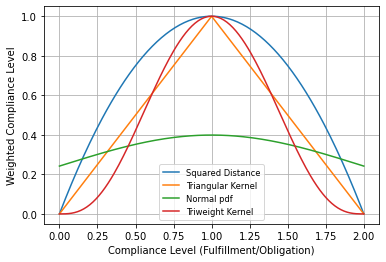

In [18]:
# this graph shows the idea that all the functions 

linspace = np.arange(0,2.01,0.01)

plt.plot(linspace, [efeito_cota(x) for x in linspace], label = "Squared Distance")
plt.plot(linspace, [linear_cota(x) for x in linspace], label = "Triangular Kernel")
plt.plot(linspace, [norm_pdf_1(x) for x in linspace], label = "Normal pdf")
plt.plot(linspace, [triweight(x) for x in linspace], label = "Triweight Kernel")

plt.grid(True)
plt.legend(fontsize= 'small')

plt.xlabel('Compliance Level (Fulfillment/Obligation)')
plt.ylabel('Weighted Compliance Level')

plt.savefig('Compliance_kernels.png', bbox_inches='tight')

### Creating flag for transfers

In [19]:
# NaN transfers fields fulfilled as 1

cota[['TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']] = cota[['TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']].fillna(value=0)

In [20]:
cota.loc[:,'TRANSF_FLAG'] = 0

In [21]:
cota.loc[(cota.TRANSF_ORIGEM != 0)|(cota.TRANSF_RECEBIDOS != 0),'TRANSF_FLAG'] = 1

In [22]:
cota.TRANSF_FLAG.value_counts()

0    1207
1     453
Name: TRANSF_FLAG, dtype: int64

### Further data cleansing (reindex, inserting missing transfer values)

In [23]:
cota.set_index(['REGISTRO DO COMPLEXO'], inplace=True)

In [24]:
cota.drop(['index'], axis=1, inplace=True)

### Exporting multiplex-level quotas

In [25]:
cota.columns

Index(['ANO_CINEMATOGRAFICO', 'REGISTRO DO GRUPO', 'NOME DO GRUPO',
       'REGISTRO DA EMPRESA', 'NOME DA EMPRESA', 'NOME DO COMPLEXO',
       'TOTAL SALAS DO COMPLEXO', 'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL',
       'OBRIGAÇÃO_TOTAL_INCREMENTO', 'OBRIGAÇÃO_PROP_INCREMENTO',
       'OBRIGAÇÃO_TOTAL', 'OBG_FINAL', 'Nº DE DIAS VALIDADOS',
       'Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO',
       'Nº DE TÍTULOS DIFERENTES DECLARADOS', 'CUMPRIU COTA', 'TRANSF_ORIGEM',
       'TRANSF_RECEBIDOS', 'OBRIGAÇÃO_TOTAL_POR_SALA',
       'OBRIGAÇÃO_TOTAL_INCREMENTO_POR_SALA', 'OBRIGAÇÃO_PROP_POR_SALA',
       'OBRIGAÇÃO_PROP_INCREMENTO_POR_SALA', 'OBRIGAÇÃO_FINAL_POR_SALA',
       'CUMPRIMENTO_PROPORCIONAL', 'DIAS_FUNC_INFERIDOS',
       'CUMPRIMENTO_PROP_TRUNCADO', 'CUMPRIMENTO_LINEAR',
       'CUMPRIMENTO_NORMALIZADO', 'CUMPRIMENTO_TRIWEIGHT', 'TRANSF_FLAG'],
      dtype='object')

In [26]:
# exporting

cota.to_csv('Cota_fiscalizacao_2017_2019.csv')

### Group-level quotas

In [50]:
# grouping now at group and not multiplex level; note col titles is an object columns, so values are haywire

# after cota para grupo defined before
cota_grupo = cota_para_grupo.groupby(['ANO_CINEMATOGRAFICO', 'REGISTRO DO GRUPO'], as_index=False).agg({
    'NOME DO GRUPO':'first','REGISTRO DA EMPRESA':'count','REGISTRO DO COMPLEXO':'count',
    'TOTAL SALAS DO COMPLEXO':'sum', 'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL':'sum',
    'OBRIGAÇÃO_TOTAL_INCREMENTO':'sum', 'OBRIGAÇÃO_PROP_INCREMENTO':'sum', 'OBRIGAÇÃO_TOTAL':'sum', 
    'OBG_FINAL':'sum', 'Nº DE DIAS VALIDADOS':'sum', 'Nº DE TÍTULOS DIFERENTES OBRIGAÇÃO':'sum',
    'Nº DE TÍTULOS DIFERENTES DECLARADOS':'sum','TRANSF_ORIGEM':'sum', 'TRANSF_RECEBIDOS':'sum'
})

In [51]:
# look item 1.3 for references

cota_grupo.loc[:,'OBRIGAÇÃO_TOTAL_POR_SALA'] = (cota_grupo.loc[:,'OBRIGAÇÃO_TOTAL'] / cota_grupo.loc[:,'TOTAL SALAS DO COMPLEXO'])

cota_grupo.loc[:,'OBRIGAÇÃO_TOTAL_INCREMENTO_POR_SALA']=(cota_grupo.loc[:,'OBRIGAÇÃO_TOTAL_INCREMENTO']/cota_grupo.loc[:,'TOTAL SALAS DO COMPLEXO'])

cota_grupo.loc[:,'OBRIGAÇÃO_PROP_POR_SALA'] = (cota_grupo.loc[:,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL'] / cota_grupo.loc[:,'TOTAL SALAS DO COMPLEXO'])

cota_grupo.loc[:,'OBRIGAÇÃO_PROP_INCREMENTO_POR_SALA'] = (cota_grupo.loc[:,'OBRIGAÇÃO_PROP_INCREMENTO'] / cota_grupo.loc[:,'TOTAL SALAS DO COMPLEXO'])

cota_grupo.loc[:,'OBRIGAÇÃO_FINAL_POR_SALA'] = (cota_grupo.loc[:,'OBG_FINAL'] / cota_grupo.loc[:,'TOTAL SALAS DO COMPLEXO'])

cota_grupo.loc[:,'CUMPRIMENTO_PROPORCIONAL'] = (cota_grupo.loc[:,'Nº DE DIAS VALIDADOS'] / cota_grupo.loc[:,'OBG_FINAL'])

cota_grupo.loc[:,'DIAS_FUNC_INFERIDOS'] = (cota_grupo.loc[:,'Nº DE DIAS OBRIGAÇÃO PROPORCIONAL'] / cota_grupo.loc[:,'OBRIGAÇÃO_TOTAL'])*365

#### Compliance-level functions

In [52]:
# applying function to prop fulfillment and adding results to cota df
cota_grupo.loc[:,'CUMPRIMENTO_PROP_TRUNCADO'] = list(map(efeito_cota, cota_grupo.CUMPRIMENTO_PROPORCIONAL))
cota_grupo.loc[:,'CUMPRIMENTO_LINEAR'] = list(map(linear_cota, cota_grupo.CUMPRIMENTO_PROPORCIONAL))
cota_grupo.loc[:,'CUMPRIMENTO_NORMALIZADO'] = list(map(norm_pdf_1, cota_grupo.CUMPRIMENTO_PROPORCIONAL))
cota_grupo.loc[:,'CUMPRIMENTO_TRIWEIGHT'] = list(map(linear_cota, cota_grupo.CUMPRIMENTO_PROPORCIONAL))

#### Further data cleansing (reindex, inserting missing transfer values) and export

In [53]:
# look at 3 above
cota_grupo[['TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']] = cota_grupo[['TRANSF_ORIGEM', 'TRANSF_RECEBIDOS']].fillna(value=0)

In [54]:
cota_grupo.set_index(['REGISTRO DO GRUPO'], inplace=True)

In [55]:
# exporting

cota_grupo.to_csv('Cota_grupo_fiscalizacao_2017_2019.csv')

### Some graphs

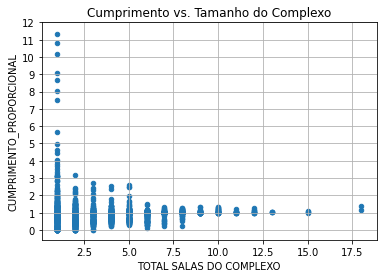

In [36]:
cota.plot.scatter(x='TOTAL SALAS DO COMPLEXO',y='CUMPRIMENTO_PROPORCIONAL', grid=True, yticks=[x for x in range(13)],
                 title="Cumprimento vs. Tamanho do Complexo")

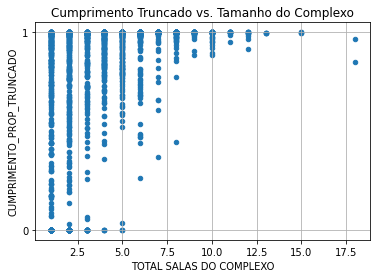

In [37]:
cota.plot.scatter(x='TOTAL SALAS DO COMPLEXO',y='CUMPRIMENTO_PROP_TRUNCADO', grid=True, yticks=[x for x in range(2)],
                 title="Cumprimento Truncado vs. Tamanho do Complexo")

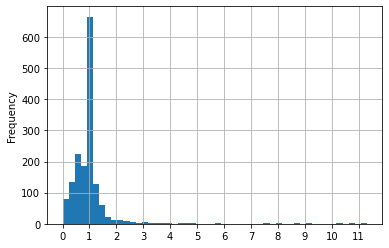

In [40]:
cota['CUMPRIMENTO_PROPORCIONAL'].plot.hist(bins=50, xticks=list(range(12)), grid=True)